In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = '/mnt/scratch/rebac002/data/AllPositive2'
#path_data = '/mnt/scratch/louwe015/Mass_differences/data'
sys.path.insert(0, ROOT)

In [2]:
import pickle
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as filename:
    spectrums = pickle.load(filename)

Text(0, 0.5, 'number of spectra in respective bin')

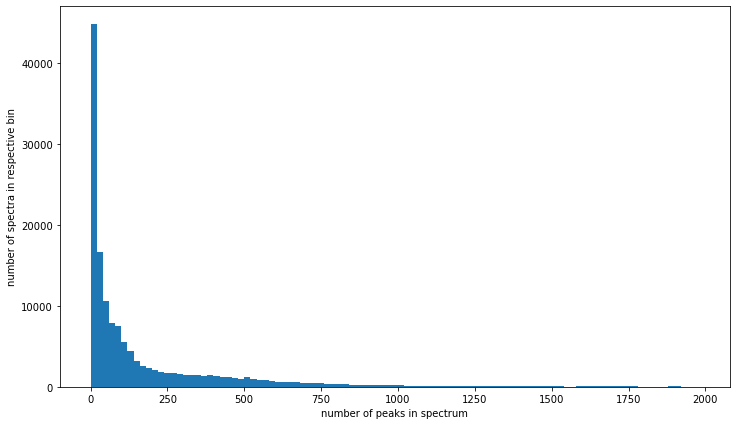

In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

**Post-process data**

We here do different post-processing for either the "classical" scores (Cosine, modified Cosine) or Spe2Vec. The reason for this is mostly to make sure that we do full justice to the classical similarity measures.

**Post-processing for classical scores**
Cosine and modified cosine scores are build on multiplying intensities of matching peaks. Small peaks (<0.01) hence contribute very little to the final scores and are left out to avoid excessive computation times.

-normalize peaks (maximum intensity to 1)
-remove peaks outside [0, 1000] m/z window
-remove spectra with < 10 peaks
-remove peaks with intensities < 0.01 of maximum intensity.

**Post-processing for Spec2Vec**
Spec2Vec similarity scores rely on creating a document vector for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.

-normalize peaks (maximum intensity to 1)
-remove peaks outside [0, 1000] m/z window
-remove spectra with < 10 peaks
-reduce number of peaks to maximum of 0.5 * parent mass
-remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_classical(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums_classical = [post_process_classical(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_classical = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums_classical)))

115388 remaining spectra.


In [5]:
import pickle
pickle.dump(spectrums_classical, 
            open(os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle'), "wb"))

In [6]:
import pickle
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums_classical = pickle.load(file)

In [7]:
def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

115388 remaining spectra.


In [8]:
pickle.dump(spectrums_s2v, 
            open(os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle'), "wb"))

In [9]:
outfile = os.path.join(path_data,'ALL_GNPS_210125_positive_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums_s2v = pickle.load(file)

In [10]:
np.max(number_of_peaks)

44945

Text(0, 0.5, 'number of spectra in respective bin')

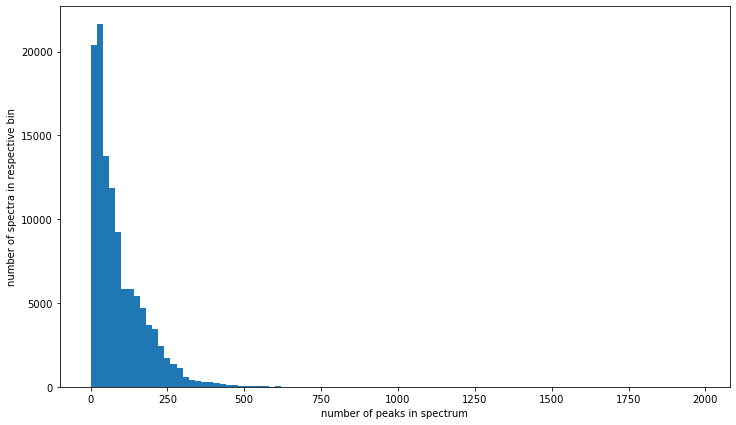

In [11]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

**Inspect annotations**

In [12]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))

inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:20]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
SRIGHEHXEGELQJ    338
IQGPMZRCLCCXAG    308
FYVNIFOYDIIODX    235
RWKUXQNLWDTSLO    235
IIZPXYDJLKNOIY    235
BHWGKAVGUMMQIW    230
QIBZFHLFHCIUOT    225
ZAYXPDDGEIJGGW    212
QJWDAOSZZYVBJZ    211
KILNVBDSWZSGLL    209
RFVFQQWKPSOBED    203
IRYMXEVDAKMFIF    198
IESVDEZGAHUQJU    197
SNKAWJBJQDLSFF    196
LFUDDCMNKWEORN    195
JLPULHDHAOZNQI    182
XGGMHQYOVYWRLV    180
LSOWKZULVQWMLY    180
dtype: int64

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

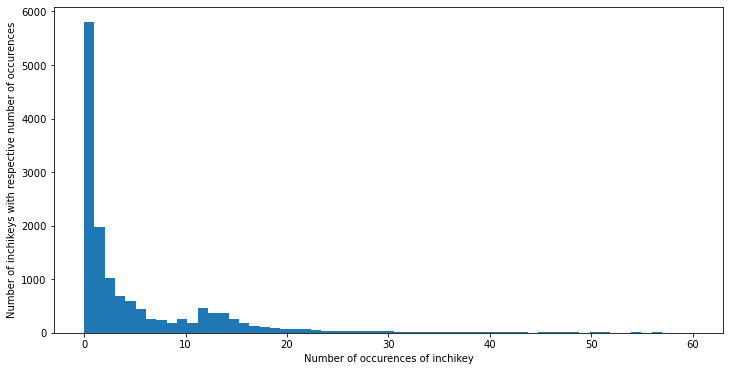

In [13]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

**Randomly select 1000 inchikeys that exist >=30 times in the dataset**

In [14]:
min_copies_in_data = 30 #min nr of spectra per inchikey

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,NEGQHKSYEYVFTD,432
1,SULIDBRAXVDKBU,426
2,SRIGHEHXEGELQJ,338
3,IQGPMZRCLCCXAG,308
5,RWKUXQNLWDTSLO,235
6,IIZPXYDJLKNOIY,235
4,FYVNIFOYDIIODX,235
7,BHWGKAVGUMMQIW,230
8,QIBZFHLFHCIUOT,225
9,ZAYXPDDGEIJGGW,212


In [15]:
print(f"Number of spectra with inchikeys that exist >= {min_copies_in_data} times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >= 30 times: 404


In [16]:
num_spectra = 100 #how many do you want to randomly select?
np.random.seed(35) # to make it reproducible

selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:20]) #select an n amount from the randomly selected
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:20]

[105  10 153 352 400 148 364 360 224 297 250 334 116  77 279 288 101  49
  17 103]


array(['TTWJBBZEZQICBI', 'QJWDAOSZZYVBJZ', 'HPNSFSBZBAHARI',
       'MCWXGJITAZMZEV', 'CLEXYFLHGFJONT', 'QUQPHWDTPGMPEX',
       'LNEPOXFFQSENCJ', 'WQZGKKKJIJFFOK', 'MUMGGOZAMZWBJJ',
       'DNTGGZPQPQTDQF', 'OXASEZHJIONDOQ', 'NGFMICBWJRZIBI',
       'REFJWTPEDVJJIY', 'SVOUGFFDROZBJI', 'ODKSFYDXXFIFQN',
       'SOSLMHZOJATCCP', 'UATOAILWGVYRQS', 'XSDQTOBWRPYKKA',
       'JLPULHDHAOZNQI', 'RPTUKVYGSPDHGQ'], dtype=object)